## Show results - Test area (Zürich)

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
#import palettable (is not working...)
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../src/util')
sys.path.append('../../src/write_entities')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from stacked_grouped_barplot import plot_clustered_stacked
from stacked_grouped_barplot_error \
import plot_clustered_stacked_with_error
from define_exposures import call_exposures
from shapefile_masks import vector_shapefile_mask

fig_dir = '../figures/'

2020-07-14 11:22:04,576 - climada - DEBUG - Loading default config file: C:\Users\valen\Documents\GitHub\climada_python\climada\conf\defaults.conf


## Damage cost for each scenario, year and labor type

In [2]:
#First we import and open the pickle file containing a dictionnary of the losses. 
#The dictionnary is a nested dictionnary, with the first layer being the different scenarios, 
#the second the years. For each scenario and each year, there is a panda dataframe 
#with the 4 types of exposures as columns, according to the level of physical activity 
#of the labor performed (the different exposures).
#The rows of the panda dataframe correspond to the output of each Monte Carlo run.

pickle_in = \
open('../../output/impact_cantons/loss_all_branches_1mc_all_uncertainties_Zürich.pickle','rb')
loss_CH= pickle.load(pickle_in)  

# Add a column to each dataframe with the sum of all exposures for each monte carlo.
for s_ in loss_CH:
    for y_ in loss_CH[s_]:     
        loss_CH[s_][y_]['total'] \
        = loss_CH[s_][y_][list(loss_CH[s_][y_].columns)].sum(axis=1)   
        
RCPs = {'RCP26':'RCP2.6','RCP45':'RCP4.5', 'RCP85':'RCP8.5'} #to get the correct name in the plots

Text(0, 0.5, 'Annual Loss (Million CHF)')

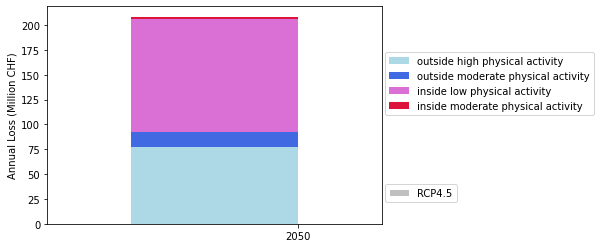

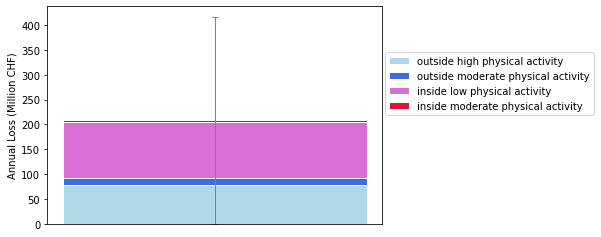

In [3]:
#We make a new dictionnary of the scenarios, with the different types of exposures
#as columns and the years in the rows. Then, the clustered stacked barplots can be called, 
#with the dictionnary of panda median as input, where the rows of each dataframe correspond to the grouping 
#criteria (by year), the columns to the stacks (the labor types) 
#and the dictionnary keys to the hatches (the scenario).  

median = {}
minimums = {}
maximums = {}

for s_ in loss_CH:
    median[RCPs[s_]] = pd.DataFrame()#dataframe containing the median realization for the different exposures
    maximums[RCPs[s_]] = pd.DataFrame() #dataframe containing the 95th percentile realization for the different exposures
    minimums[RCPs[s_]] = pd.DataFrame()#dataframe containing the 5th percentile realization for the different exposures
    
    for y_ in loss_CH[s_]:
        median[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).median())/1e6  #don't need the total here 
        maximums[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).quantile(0.95))/1e6 
        minimums[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).quantile(0.05))/1e6
    
    median[RCPs[s_]] = median[RCPs[s_]].transpose()
    maximums[RCPs[s_]] = maximums[RCPs[s_]].transpose()
    minimums[RCPs[s_]] = minimums[RCPs[s_]].transpose()

fig, ax = plt.subplots()
plot_clustered_stacked(median,title = '',color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Loss (Million CHF)')
ax.ticklabel_format(style='plain')

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065.pdf']),bbox_inches='tight')

fig, ax = plt.subplots()
plot_clustered_stacked_with_error(median,minimums,maximums,color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Loss (Million CHF)')

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065_werror.pdf']),bbox_inches='tight')
